# BSI prediction - Logistic regression

295
Train Test split completed : ( Test size 0.20 )
Optimization terminated successfully.
         Current function value: 0.143343
         Iterations 11
Train Test split completed : ( Test size 0.20 )
Custom scorer : make_scorer(fbeta_score, beta=2)



Gridsearch off
Accuracy of Logistic regression classifier on train set: :0.955
Accuracy of Logistic regression classifier on test set: :0.956
Threshold optimization
[[569 277]
 [  7  32]]
              precision    recall  f1-score   support

           0       0.99      0.67      0.80       846
           1       0.10      0.82      0.18        39

    accuracy                           0.68       885
   macro avg       0.55      0.75      0.49       885
weighted avg       0.95      0.68      0.77       885



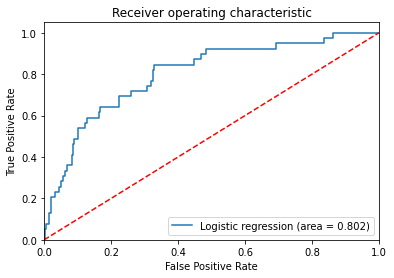

Mean ROC AUC score : 0.823
Relapse time : 1.975


<Figure size 432x288 with 0 Axes>

In [5]:
import time
import sys
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,brier_score_loss,log_loss,fbeta_score, make_scorer,accuracy_score,matthews_corrcoef,f1_score,precision_score,recall_score,precision_recall_curve,confusion_matrix
from Functions_logisticregression import selectFeatures,extractCoefficient,plotROC,plotPRcurve,plotKfoldROC,plotPRAUC,logloss_plot,brierloss_plot,plotCalibratedProb,hyperParamOptimization
from generalFunctions import sensitivity_specifity_cutoff
from shap.utils._general import OpChain
from shap import Explanation
import statsmodels.api as sm

def convert_ordering(ordering, shap_values):
    if issubclass(type(ordering), OpChain):
        ordering = ordering.apply(Explanation(shap_values))
    if issubclass(type(ordering), Explanation):
        if "argsort" in [op["name"] for op in ordering.op_history]:
            ordering = ordering.values
        else:
            ordering = ordering.argsort.flip.values
    return ordering


def plotKfoldROC(X_train, y_train, clf, kfold, modelname):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    #plt.figure()
    fold = 1
    mean_auc = [] 
    mean_pr_auc=[] 
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        clf.fit(X_train_fold, y_train_fold)

        clf_roc_auc = roc_auc_score(y_test_fold, clf.predict_proba(X_test_fold)[:, 1])
        fpr, tpr, thresholds = roc_curve(y_test_fold, clf.predict_proba(X_test_fold)[:, 1])
        mean_auc.append(clf_roc_auc)
        #plt.plot(fpr, tpr, label='Fold %s (area = %0.3f)' % (fold, clf_roc_auc))
        #plt.plot([0, 1], [0, 1], 'r--')
        #plt.xlim([0.0, 1.0])
        #plt.ylim([0.0, 1.05])
        fold += 1
        #plt.xlabel('False Positive Rate')
        #plt.ylabel('True Positive Rate')
        #plt.title('Receiver operating characteristic\n%s' % modelname)
        #plt.legend(loc="lower right")
        #plt.savefig('Log_ROC')
        
        prec, recall, _ = precision_recall_curve(y_test_fold, clf.predict_proba(X_test_fold)[:, 1]) # 추가 20220729
        auc_score = auc(recall, prec) 
        mean_pr_auc.append(auc_score) 
    cv_roc_auc = np.mean(mean_auc)
    cv_pr_auc=np.mean(mean_pr_auc) 
    print('Mean ROC AUC score : %.3f' % cv_roc_auc)
    #plt.show()
    #plt.clf()
    return cv_roc_auc, cv_pr_auc 

def splitXY(df_merge, all_features):
    X = df_merge[all_features]
    #Y = df_merge['Septic_shock_Fin']
    Y = df_merge['BSI']
    #Y = df_merge['Septic_shock']
    PID = df_merge['patient_Identifier']
    return X, Y, PID

# USAGE : X_train, X_test, y_train, y_test = splitTrainTest(X, Y, seed, testsize)

def splitTrainTest(X, Y, seed, testsize, PID):
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=seed, test_size=testsize)
    pid_lst_train = PID.loc[X_train.index].reset_index(drop=True)
    pid_lst_test = PID.loc[X_test.index].reset_index(drop=True)
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    print('Train Test split completed : ( Test size %.2f )' % testsize)

    return X_train, X_test, y_train, y_test, pid_lst_train, pid_lst_test

def standardScaleData(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[Feature_lst])
    X_test_scaled = scaler.fit_transform(X_test[Feature_lst])
    scaled_data_X_train = np.concatenate([X_train_scaled, X_train[Feature_OHE]], axis=1)
    scaled_data_X_test = np.concatenate([X_test_scaled, X_test[Feature_OHE]], axis=1)

    return scaled_data_X_train, scaled_data_X_test

all_features=['Hct', 'Hb', 'Platelet', 'RBC', 'WBC', 'ALT_SGPT', 'AST_SGOT',
       'Total_bilirubin', 'Creatinine', 'Total_protein', 'Albumin',
       'Alkaline_phosphatase', 'Uric_acid', 'Sodium', 'Potassium', 'Chloride',
       'BUN', 'Phosphorus', 'CRP', 'E-ANC', 'Heart_rate', 'Respiration_rate',
       'Systolic_BP', 'Diastolic_BP', 'Temperature', 'AML', 'ANC_100']

Feature_lst=[ 'Hct', 'Hb', 'Platelet', 'RBC', 'WBC', 'ALT_SGPT', 'AST_SGOT',
       'Total_bilirubin',  'Total_protein', 'Albumin',
       'Alkaline_phosphatase', 'Uric_acid', 'Sodium', 'Potassium', 'Chloride',
       'BUN', 'Phosphorus', 'CRP', 'E-ANC', 'Temperature' ]

Feature_OHE=['Creatinine',  'Heart_rate', 'Respiration_rate',
       'Systolic_BP', 'Diastolic_BP', 'AML', 'ANC_100']

df_merge = pd.read_csv('data final.tsv',sep='\t',encoding='cp949')

df_merge.rename(columns={'Temperature':'Temperature_rm'},inplace=True)
df_merge.rename(columns={'체온값_max':'Temperature','ANC<100':'ANC_100'},inplace=True)
all_features=['Hct','Hb','Platelet','RBC','WBC','ALT_SGPT','AST_SGOT','Total_bilirubin','Creatinine','Total_protein','Albumin','Alkaline_phosphatase',
             'Uric_acid','Sodium','Potassium','Chloride','BUN','Phosphorus','CRP','E-ANC','Heart_rate',
             'Respiration_rate','Systolic_BP','Diastolic_BP','Temperature','AML','ANC_100']

##### set seed
seed = 295
print(seed)

testsize = 0.2
# clf - before optimization
n_splits = 5
clf = LogisticRegression(random_state=seed,max_iter=10000,C=0.01)
modelname = 'Logistic regression'

## 
number_of_features = len(all_features)  # FIXME: RFE

start = time.time()

####
lst_cv_seeds = []
lst_cv_scoringmethod = []
lst_cv_score = []

lst_trainset_score = []
lst_testset_score = []

#####  DataFrame -> Feature , Label separation
X, Y, PID = splitXY(df_merge,all_features)

#####  Train, Test set split
X_train, X_test, y_train, y_test, pid_lst_train ,pid_lst_test = splitTrainTest(X, Y, seed, testsize,PID)


############################# 
all_features_addcon=['constant']+all_features
X_train_with_intercept = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_with_intercept)
result = logit_model.fit()
lst_pval=[]
lst_pval_seed=[]
lst_pval_features=[]
selected_features=[]
for i in np.where(result.pvalues.values<0.05)[0]:
    if all_features_addcon[i]=='constant':
        continue
    lst_pval_seed.append(seed)
    selected_features.append(all_features_addcon[i])
    lst_pval_features.append(all_features_addcon[i])
    lst_pval.append(result.pvalues.values[i])

if selected_features[0] == 'constant':
    selected_features=selected_features[1:]

all_features=selected_features
number_of_features = len(all_features)
X, Y, PID = splitXY(df_merge,all_features)            
X_train, X_test, y_train, y_test, pid_lst_train ,pid_lst_test = splitTrainTest(X, Y, seed, testsize,PID)

################################# add end
clf.fit(X_train, y_train)  # before RFE

##### Feature selection & model fit
lst_selected_idx, lst_selected_featurename = selectFeatures(clf, number_of_features, X_train, y_train, all_features,
                                                            X)  # Feature selection


X_train = X_train.iloc[:, lst_selected_idx]
#X_train = X_train[:, lst_selected_idx]
X_test = X_test.iloc[:, lst_selected_idx]
#X_test = X_test[:, lst_selected_idx]

X_train=np.array(X_train)
X_test=np.array(X_test)        

clf.fit(X_train, y_train)  # after RFE 

##### Grid search
custom_scorer = make_scorer(fbeta_score, beta=2)
mcc_scorer=make_scorer(matthews_corrcoef)
# roc_auc , f1 , accuracy etc. #FIXME: Scorer
print('Custom scorer : %s' % custom_scorer)
print('\n\n')
#tuning = input('GridsearchCV (on/off) : ')
tuning = 'on'
try:
    if tuning == 'on':
        parameters = {'class_weight':'balanced','C':0.01}
        score_df = hyperParamOptimization(clf,parameters, custom_scorer, X_train, y_train)
        print('Before update')
        print(clf)
        print('#######################################################')
        clf.set_params(**score_df.sort_values('rank_test_score').reset_index(drop=True)['params'][0])
        clf.fit(X_train, y_train)
        print('Updated')
        print(clf)
except:
    print('Gridsearch off')
    pass
coef_result = extractCoefficient(clf, X_train, y_train, lst_selected_featurename)  # RFE 이후 coefficient extract
coef_result['Seed']=seed 
coef_result['Coefficient_abs']=list(abs(coef_result['Coefficient']))
coef_result=coef_result.sort_values('Coefficient',ascending=False)
coef_result['Rank']=list(range(1,len(all_features)+1))
coef_result=coef_result.sort_values('Coefficient_abs',ascending=False)
coef_result['Rank_abs']=list(range(1,len(all_features)+1))
coef_result.reset_index(drop=True)


selfeatures=list(coef_result['Var'])
#selfeatures.sort()

# 5. K-fold cross validation
kfold = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
scoringlst = ['accuracy', 'roc_auc', 'f1', custom_scorer]  # FIXME:

for i in scoringlst:
    results = model_selection.cross_val_score(clf, X_train, y_train, cv=kfold, scoring=i)
    #print('%i-fold cross validation %s : %.3f' % (n_splits, i, results.mean()))

# 6. Performance - Test set
pred_train = clf.predict(X_train)  
pred_test = clf.predict(X_test)
print('Accuracy of %s classifier on train set: :%.3f'%(modelname, clf.score(X_train, y_train)))
print('Accuracy of %s classifier on test set: :%.3f'%(modelname, clf.score(X_test, y_test)))
lst_trainset_score.append(clf.score(X_train, y_train))
lst_testset_score.append(clf.score(X_test, y_test))

clf.fit(X_train, y_train)
conf_matrix = confusion_matrix(y_test, pred_test) 
#print(conf_matrix) 
J=sensitivity_specifity_cutoff(y_test, clf.predict_proba(X_test)[:,1])
pred_test_J=(clf.predict_proba(X_test)[:,1]>J).astype('int') 
confusion_matrix_J = confusion_matrix(y_test,pred_test_J) 
tn, fp, fn, tp = confusion_matrix(y_test,pred_test_J).ravel() 
print('Threshold optimization') 
#print('Optimal threshold : %.3f'%J) 
print(confusion_matrix_J) 
var_sens=tp/(tp+fn)
var_spec=tn/(fp+tn)
var_PPV=tp/(tp+fp)
var_NPV=tn/(tn+fn)
var_PLR=(tp/(tp+fn))/(fp/(fp+tn))
var_NLR=(fn/(tp+fn))/(tn/(fp+tn))

y_prob_model1=clf.predict_proba(X_test)[:,1]
fpr_model1,tpr_model1,_=roc_curve(y_test,y_prob_model1)
roc_auc_model1 = roc_auc_score(y_test, y_prob_model1)

print(classification_report(y_test, pred_test_J))

from sklearn.metrics import auc
prec, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
auc_score = auc(recall, prec)

explainer = shap.Explainer(clf, X_train,feature_names=lst_selected_featurename)
shap_values = explainer(X_test)

#shap.plots.beeswarm(shap_values,max_display=71, order=shap_values.abs.max(0))    

# 7. ROC
plotROC(clf, X_test, y_test, clf.predict_proba(X_test)[:,1], modelname) # 
cv_roc_auc,cv_pr_auc = plotKfoldROC(X_train, y_train, clf, kfold, modelname)
#plotPRAUC(clf, X_train, y_train, X_test, y_test, seed, modelname)
#cv_brier=plotCalibratedProb(clf,X_train, y_train, kfold, modelname)
#plotPRcurve(y_test, clf.predict_proba(X_test)[:, 1])
#return X_train, X_test, y_train, y_test, clf, kfold, cv_roc_auc, df_CV
print('Relapse time : %.3f' % (time.time() - start))